<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Data-Analysis-Projects/blob/master/LA_Parking_Citation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LA Parking Citation Analysis

This dataset of parking citations for the city of Los Angeles. Parking citations with latitude / longitude (XY) in US Feet coordinates according to the NAD_1983_StatePlane_California_V_FIPS_0405_Feet projection.

### Analysis performed by:

Ken Wood

Senior Marketing Strategist

ken@roarmarketingconcepts.com




---



### Mount my Google Drive where the Olist datasets are located...

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!apt install proj-bin libproj-dev libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [3]:
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
!sudo pip install -U git+https://github.com/matplotlib/basemap.git

    100% |████████████████████████████████| 132.4MB 270kB/s 
  Running setup.py bdist_wheel for basemap ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /tmp/pip-ephem-wheel-cache-t2s2nrc5/wheels/6c/c2/bd/d6fb8f2660e0591d357352aba1b117b3211d016994d933d792
Successfully built basemap
  Found existing installation: basemap 1.2.0
    Uninstalling basemap-1.2.0:
      Successfully uninstalled basemap-1.2.0
  [mpl_toolkits]
You must restart the runtime in order to use newly installed versions.
  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-feqfvcyd
  Running setup.py bdist_wheel for basemap ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-2mubpbo1/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
Successfully built basemap
  Found existing install

### Install some necessary packages to perform the required analysis...

In [28]:
!pip install -U scikit-learn
!pip install --user --upgrade tables

import pandas as pd
import numpy as np
import sklearn
import scipy
import calendar
from datetime import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import interactive
plt.rc("font", size=14)
from pylab import scatter, show, legend, xlabel, ylabel

from mpl_toolkits.basemap import Basemap

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.4.4)


In [5]:
"""width = 28000000; lon_0 = -105; lat_0 = 40
m = Basemap(width=width,height=width,projection='aeqd',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary(fill_color='aqua')
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='coral',lake_color='aqua')
# 20 degree graticule.
m.drawparallels(np.arange(-80,81,20))
m.drawmeridians(np.arange(-180,180,20))
# draw a black dot at the center.
xpt, ypt = m(lon_0, lat_0)
m.plot([xpt],[ypt],'ko')
# draw the title.
plt.title('Azimuthal Equidistant Projection')
plt.show()"""

"width = 28000000; lon_0 = -105; lat_0 = 40\nm = Basemap(width=width,height=width,projection='aeqd',\n            lat_0=lat_0,lon_0=lon_0)\n# fill background.\nm.drawmapboundary(fill_color='aqua')\n# draw coasts and fill continents.\nm.drawcoastlines(linewidth=0.5)\nm.fillcontinents(color='coral',lake_color='aqua')\n# 20 degree graticule.\nm.drawparallels(np.arange(-80,81,20))\nm.drawmeridians(np.arange(-180,180,20))\n# draw a black dot at the center.\nxpt, ypt = m(lon_0, lat_0)\nm.plot([xpt],[ypt],'ko')\n# draw the title.\nplt.title('Azimuthal Equidistant Projection')\nplt.show()"

In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Load the dataset...

In [29]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/LA Parking Citations/los-angeles-parking-citations/parking-citations.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
df.isnull().sum()

Ticket number                  0
Issue Date                   535
Issue time                  2590
Meter Id                 6472588
Marked Time              8456519
RP State Plate               765
Plate Expiry Date         797010
VIN                      8731405
Make                        8767
Body Style                  8898
Color                       4119
Location                     854
Route                      65389
Agency                       544
Violation code                 0
Violation Description        874
Fine amount                 6514
Latitude                       3
Longitude                      3
dtype: int64

### We drop the columns 'Meter Id', 'Marked Time', and 'VIN' since  most of their values are missing...

In [0]:
df.drop(['Meter Id','Marked Time','VIN'],axis=1,inplace=True)

### Let's convert all date fields to pandas 'datetime' variables so that we can easily work with dates and times in our analysis.

In [0]:
def CreateDateTimeVariable(column):
  column.fillna(0.0,inplace=True)
  column = column/100
  column = pd.to_datetime(column,format='%H.%M',errors = 'coerce').dt.time
  column = pd.to_datetime(column,format='%H:%M:%S').dt.time
  return column

In [0]:
df['Issue Date'] = pd.to_datetime(df['Issue Date'],format = '%Y-%m-%d')
df['Issue Date Month'] = df['Issue Date'].dt.month
df['Issue Date Day'] = df['Issue Date'].dt.day
df['Issue Date Day of Week'] = df['Issue Date'].dt.weekday_name

df['Issue time'] = CreateDateTimeVariable(df['Issue time'])

df['Plate Expiry Date'].fillna(value = 201812.0,inplace=True)
df['Plate Expiry Date'] = df['Plate Expiry Date']/100
number_dec = df['Plate Expiry Date']%1
number_dec.where(number_dec<=0.12,0.12)
df['Plate Expiry Date'] = df['Plate Expiry Date'].astype(np.int64) + number_dec
df['Plate Expiry Date'] = df['Plate Expiry Date'].astype(str)
df['Plate Expiry Date'] = pd.to_datetime(df['Plate Expiry Date'],format='%Y.%m',errors='coerce')

In [35]:
citations_per_month = df.groupby(df['Issue Date Month'])['Ticket number'].count().reset_index()
citations_per_month.rename(columns = {'Ticket number': 'Number of Tickets'},inplace=True)
citations_per_month

,Issue Date Month,Number of Tickets
0,1.0,807946
1,2.0,684398
2,3.0,796876
3,4.0,732434
4,5.0,753638
5,6.0,743998
6,7.0,697655
7,8.0,760805
8,9.0,670347
9,10.0,717951


### Let's get a barchart of the number of tickets issued per month...




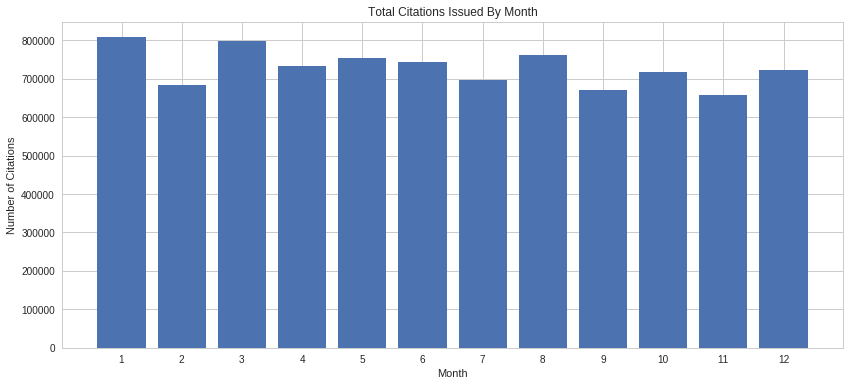

In [36]:
fig,ax = plt.subplots(figsize=(14,6))

plt.bar(citations_per_month['Issue Date Month'],citations_per_month['Number of Tickets'])
plt.xticks(citations_per_month['Issue Date Month'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of Citations')
ax.set_title('Total Citations Issued By Month')

plt.show()

In [38]:
citations_per_weekday = df.groupby(df['Issue Date Day of Week'])['Ticket number'].count().reset_index()
citations_per_weekday.rename(columns = {'Ticket number': 'Number of Tickets'},inplace=True)
citations_per_weekday

,Issue Date Day of Week,Number of Tickets
0,Friday,1424611
1,Monday,1427306
2,Saturday,492124
3,Sunday,446726
4,Thursday,1638213
5,Tuesday,1701473
6,Wednesday,1616726


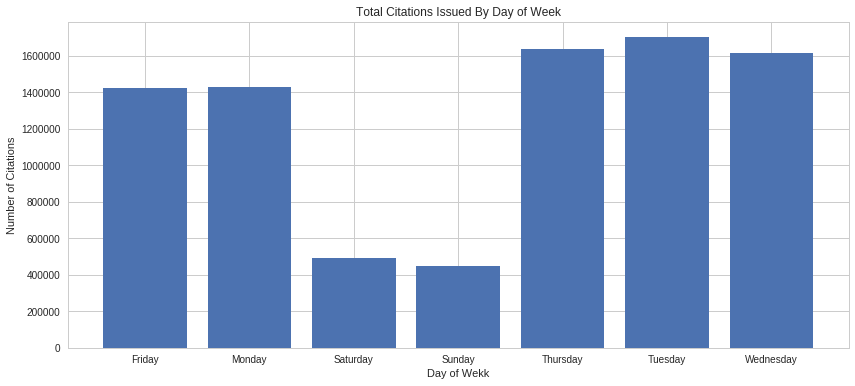

In [43]:
fig,ax = plt.subplots(figsize=(14,6))

plt.bar(citations_per_weekday['Issue Date Day of Week'],citations_per_weekday['Number of Tickets'])
plt.xticks(citations_per_weekday['Issue Date Day of Week'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Citations')
ax.set_title('Total Citations Issued By Day of Week')

plt.show()

### Let's create the marketing funnel by left joining the 'mql' and 'cd' datasets. (Note that 'NaN's are leads that did not close.)

In [0]:
mf = mql.merge(cd, on='mql_id', how='left')
print("'mf' dimensions: {}".format(mf.shape))
mf.info()

In [0]:
"""for key,value in dict.items():
  print(color.BOLD+key+color.END,value.info(),'\n')""" # print dataset name in BOLD

### Now, we want to join information from the other datasets into the marketing funnel. Based on the schema diagram, 'order_items' should be the next dataset we merge.  Let's get some information about the 'order_items' dataset... We will merge it with the marketing funnel on the 'seller_id' column.

In [0]:
order_items.info()

In [0]:
mf_items = mf.merge(order_items, how='left', on='seller_id')
mf_items['mql_id'].nunique()

In [0]:
mf_items.info()

### Let's take a look at the 'sellers' dataset...

In [0]:
sellers.info()

In [0]:
sellers['seller_id'].nunique()

### So we can conclude that the dataset has 3095 unique sellers.  Let's merge the seller information for each of the leads in the marketing funnel.

In [0]:
mf_sellers = mf.merge(sellers, how='left', on='seller_id')
mf_sellers['mql_id'].nunique()

In [0]:
mf_sellers['seller_id'].nunique()

In [0]:
geolocation.info()

###Now, in order to merge the 'geolocation' information into the marketing funnel on *zip_code_prefix*, we need to remove the duplicate values in 'geolocation' and then change the column names in both datasets.

In [0]:
geolocation['geolocation_zip_code_prefix'].value_counts()

In [0]:
geolocation = geolocation.drop_duplicates('geolocation_zip_code_prefix',keep='first')
geolocation['geolocation_zip_code_prefix'].value_counts()

In [0]:
mf_sellers.rename(columns = {'seller_zip_code_prefix':'zip_code_prefix'},inplace=True)
geolocation.rename(columns = {'geolocation_zip_code_prefix':'zip_code_prefix'},inplace=True)

### We verify that the correct columns have been renamed...

In [0]:
 # mf_sellers.info()

In [0]:
# geolocation.info()

In [0]:
mf_sellers = pd.merge(mf_sellers,geolocation[['zip_code_prefix','geolocation_lat','geolocation_lng']], how = 'left',on='zip_code_prefix')
mf_sellers.info()

### Let's take a look at the frequency of the unique values in each column of the 2 marketing funnels. For now, we will skip the id and date columns to keep our analysis clean.

## mf_items:

<class 'pandas.core.frame.DataFrame'>


### Data columns (total 23 columns):

mql_id                           12664 non-null object

first_contact_date               12664 non-null datetime64[ns]

landing_page_id                  12664 non-null object

origin                           12597 non-null object

seller_id                        5506 non-null object

sdr_id                           5506 non-null object

sr_id                            5506 non-null object

won_date                         5506 non-null datetime64[ns]

business_segment                 5505 non-null object

lead_type                        5455 non-null object

lead_behaviour_profile           3679 non-null object

has_company                      88 non-null object

has_gtin                         89 non-null object

average_stock                    91 non-null object

business_type                    5494 non-null object

declared_product_catalog_size    69 non-null float64

declared_monthly_revenue         5506 non-null float64

order_id                         5044 non-null object

order_item_id                    5044 non-null float64

product_id                       5044 non-null object

shipping_limit_date              5044 non-null datetime64[ns]

price                            5044 non-null float64

freight_value                    5044 non-null float64

dtypes: datetime64[ns](3), float64(5), object(15)

memory usage: 2.3+ MB

In [0]:
columns = ['origin','business_segment','lead_type','lead_behaviour_profile','has_company','has_gtin','average_stock',
           'business_type']

for col in columns:
    print(mf_items[col].value_counts(),'\n\n',mf_items[col].value_counts(normalize=True),'\n\n')
    

In [0]:
mf_items_origin = mf_items['origin'].value_counts(normalize=True).reset_index()

In [0]:
fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in mf_items_origin['index']:
  order.append(row)

sns.countplot(mf_items['origin'].sort_values(), order=order, palette="Blues_d")
ax.set_xlabel('Lead Source')
ax.set_title('Lead Source Distribution')

plt.show()

In [0]:
fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in mf_items_origin['index']:
  order.append(row)

sns.barplot(x ='index',y = 'origin', data = mf_items_origin, order=order, palette="Blues_d")
ax.set_xlabel('Lead Source')
ax.set_ylabel('Normalized Count - % of Total')
ax.set_title('Lead Source Distribution')

plt.show()

In [0]:
mf_items_business_segment = mf_items['business_segment'].value_counts(normalize=True).reset_index()

In [0]:
fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in mf_items_business_segment['index']:
  order.append(row)

graph = sns.barplot(x ='index',y = 'business_segment', data = mf_items_business_segment, order=order, palette="Blues_d")
ax.set_xlabel('Business Segment')
ax.set_ylabel('Normalized Count - % of Total')
ax.set_title('Business Segment Distribution')
graph.set_xticklabels(order,rotation=90)

plt.show()

In [0]:
mf_items_lead_type = mf_items['lead_type'].value_counts(normalize=True).reset_index()

In [0]:
fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in mf_items_lead_type['index']:
  order.append(row)

graph = sns.barplot(x ='index',y ='lead_type', data = mf_items_lead_type, order=order, palette="Blues_d")
ax.set_xlabel('Lead Type')
ax.set_ylabel('Normalized Count - % of Total')
ax.set_title('Lead Type Distribution')
# graph.set_xticklabels(order,rotation=90)

plt.show()

In [0]:
mf_items_lead_behaviour_profile = mf_items['lead_behaviour_profile'].value_counts(normalize=True).reset_index()

In [0]:
fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in mf_items_lead_behaviour_profile['index']:
  order.append(row)

graph = sns.barplot(x ='index',y ='lead_behaviour_profile', data = mf_items_lead_behaviour_profile, order=order, palette="Blues_d")
ax.set_xlabel('Lead Behaviour Profile')
ax.set_ylabel('Normalized Count - % of Total')
ax.set_title('Lead Behaviour Profile Distribution')
# graph.set_xticklabels(order,rotation=90)

plt.show()

In [0]:
mf_items_business_type = mf_items['business_type'].value_counts(normalize=True).reset_index()

In [0]:
fig,ax = plt.subplots(figsize=(4,4))

order = []                        # Set up order for barchart
for row in mf_items_business_type['index']:
  order.append(row)

graph = sns.barplot(x ='index',y ='business_type', data = mf_items_business_type, order=order, palette="Blues_d")
ax.set_xlabel('Business Type Profile')
ax.set_ylabel('Normalized Count - % of Total')
ax.set_title('Business Type Profile Distribution')
# graph.set_xticklabels(order,rotation=90)

plt.show()

### Now, let's look at the 'mf_sellers' dataset.  We would like to get more information about where the sellers are located.  We can use the 'geolocation_lat' and 'geolocation_lng' fields and Python's 'Basemap' package to plot geographies.  We start with a basic Basemap plot of Earth.

In [0]:
map = Basemap()

map.drawcoastlines()

plt.show()
plt.savefig('test.png')

In [0]:
map = Basemap(projection='ortho', 
              lat_0=0, lon_0=-90)

#Fill the globe with a blue color 
map.drawmapboundary(fill_color='aqua')

#Fill the continents with the land color
map.fillcontinents(color='coral',lake_color='aqua')

map.drawcoastlines()

plt.show()

In [0]:
mf_sellers.info()

### Determine range to print based on min, max lat and long of the data

In [0]:
lat = np.asarray(mf_sellers['geolocation_lat'].dropna())
lng = np.asarray(mf_sellers['geolocation_lng'].dropna())

In [0]:
from geopy.geocoders import Nominatim

geolocator = Nominatim()

def PlotCity(city):
  loc1 = geolocator.geocode(city)
  x, y = map(loc1.longitude, loc1.latitude)
  ax.plot(x, y, 'ok', markersize=10)
  plt.text(x, y, city, fontsize=12,fontweight='bold')
  return
 

In [0]:
margin = .2                     # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lng_min = min(lng) - margin
lng_max = max(lng) + margin

# create map using BASEMAP
fig,ax = plt.subplots(figsize=(14,8))

map = Basemap(llcrnrlon=lng_min,
            llcrnrlat=lat_min,
            urcrnrlon=lng_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lng_max-lng_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.drawmapboundary(fill_color='#46bcec')
map.fillcontinents(color = 'white',lake_color='#46bcec')

# convert lat and long to map projection coordinates
x,y = map(lng, lat)

# plot points as red dots

map.scatter(x,y, marker = 'o', s=20,color='r',alpha=0.35, zorder=10)

# Find and plot major cities

city_list = ['Sao Paulo','Rio de Janeiro','Curitiba','Brasilia','Natal','Uberaba','Salvador-BA','Porto Alegre','Itajai']

for city in city_list:
  PlotCity(city)

plt.title("Olist Seller Locations in Brazil",fontsize=20,fontweight='bold')
plt.show()

### Let's look at characteristics of the closed deals...

In [0]:
cd.info()

### If we merge 'cd' with 'order_items' we find out about sellers and items that associated with closed deals.

In [0]:
cd_items = cd.merge(order_items,how='left',on='seller_id')
print(cd_items['mql_id'].nunique())
cd_items.info()

### Let's determine how many 'order_id's are associated with each closed deal 'mql_id'.  We'll also determine the revenue associated with each if these 'mql_id's.

In [0]:
order_ids_per_mql = cd_items.groupby(['mql_id'])['order_id'].count().reset_index()
order_ids_per_mql = order_ids_per_mql[order_ids_per_mql.order_id != 0]  # Delete rows where count(order_id) = 0
order_ids_per_mql.rename(columns = {'order_id':'num_order_ids'},inplace=True)
order_ids_per_mql.sort_values(by='num_order_ids',ascending=False)

### Now we can merge the 'orders' and 'order_payments' and 'order_reviews' information for each 'order_id' in 'cd_items'. However, before we do that, let's add a column to the 'order_payments' dataset.

In [0]:
order_payments.head()

### We will add a column called 'total_payment' which is the product of the 'payment_installments' and 'payment_value'.

In [0]:
order_payments['total_payment'] = order_payments['payment_installments']*order_payments['payment_value']

In [0]:
from functools import reduce

dfs_to_merge = [cd_items,orders,order_payments,order_reviews]
cd_order_info = reduce(lambda left,right: pd.merge(left,right,on=['order_id'],how='left'), dfs_to_merge)
cd_order_info.info()

### What is the revenue value for each closed deal 'mql_id'?

In [0]:
revenue_per_mql = cd_order_info.groupby(['mql_id'])['total_payment'].sum().reset_index()
revenue_per_mql = revenue_per_mql[revenue_per_mql.total_payment != 0]  # Delete rows where sum(total_payment) = 0
top_20_mqls= revenue_per_mql.sort_values(by='total_payment',ascending=False).head(20)
top_20_mqls

In [0]:
import matplotlib.ticker as mtick

fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in top_20_mqls['mql_id']:
  order.append(row)

graph = sns.barplot(x ='mql_id',y ='total_payment', data = top_20_mqls, order=order, palette="Blues_d")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.set_xlabel('Closed Deal mql_id')
ax.set_ylabel('Revenue')
ax.set_title('Top 20 Closed Deal mql_ids by Revenue',fontsize=20,fontweight='bold')
graph.set_xticklabels(order,rotation=90)

plt.show()

### Let's merge the customer information into the 'cd_items' dataset...

In [0]:
cd_order_customer_info = cd_order_info.merge(customers,how='left', on='customer_id')
cd_order_customer_info.info()

### Let's merge the customer geographical location info into the 'cd_order_customer_info' dataset.

In [0]:
cd_order_customer_info.rename(columns = {'customer_zip_code_prefix':'zip_code_prefix'},inplace=True)
cd_order_customer_info = pd.merge(cd_order_customer_info,geolocation[['zip_code_prefix','geolocation_lat','geolocation_lng']], how = 'left',on='zip_code_prefix')
cd_order_customer_info.info()

In [0]:
num_customers_per_cd_mql = cd_order_customer_info.groupby(['mql_id'])['customer_id'].count().reset_index()
num_customers_per_cd_mql = num_customers_per_cd_mql[num_customers_per_cd_mql.customer_id !=0]
num_customers_per_cd_mql.rename(columns = {'customer_id': 'num_customer_ids'},inplace=True)
num_customers_per_cd_mql

In [0]:
num_products_per_cd_mql = cd_order_customer_info.groupby(['mql_id'])['product_id'].count().reset_index()
num_products_per_cd_mql = num_products_per_cd_mql[num_products_per_cd_mql.product_id !=0]
num_products_per_cd_mql.rename(columns = {'product_id': 'num_product_ids'},inplace=True)
num_products_per_cd_mql

### Let's plot the customer locations for the closed deal 'mql_id's...

In [0]:
lat = np.asarray(cd_order_customer_info['geolocation_lat'].dropna())
lng = np.asarray(cd_order_customer_info['geolocation_lng'].dropna())

In [0]:
margin = .2                     # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lng_min = min(lng) - margin
lng_max = max(lng) + margin

# create map using BASEMAP
fig,ax = plt.subplots(figsize=(14,8))

map = Basemap(llcrnrlon=lng_min,
            llcrnrlat=lat_min,
            urcrnrlon=lng_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lng_max-lng_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.drawmapboundary(fill_color='#46bcec')
map.fillcontinents(color = 'white',lake_color='#46bcec')

# convert lat and long to map projection coordinates
x,y = map(lng, lat)

# plot points as red dots

map.scatter(x,y, marker = 'o',s = 10, color='r',alpha=0.35, zorder=10)

# Find and plot major cities

city_list = ['Sao Paulo','Rio de Janeiro','Curitiba','Brasilia','Natal','Uberaba','Salvador-BA','Porto Alegre','Itajai']

for city in city_list:
  PlotCity(city)

plt.title("Olist Customer Locations in Brazil",fontsize=20,fontweight='bold')
plt.show()

### Let's get the first contact date for each of the closed deal mql_id's.  We can get that from the 'mql' dataset.

In [0]:
cd_order_customer_info = cd_order_info.merge(mql[['mql_id','first_contact_date']],how='inner', on='mql_id')
cd_order_customer_info.info()

In [0]:
cd_order_customer_info['lead_conversion_time'] = cd_order_customer_info['won_date'] - cd_order_customer_info['first_contact_date']
cd_order_customer_info['lead_conversion_time'] = cd_order_customer_info['lead_conversion_time'].dt.days  # Strip out days from timedelta variable
cd_order_customer_info['lead_conversion_time'] = cd_order_customer_info['lead_conversion_time'].apply(np.float32)
cd_order_customer_info['lead_conversion_time'].head()

### Some statistics on the lead conversion times (measured in days) for the closed deals...  Notice that the standard deviation is higher than the mean value!  Let's see how closed deal revenue affects the lead conversion time.

In [0]:
cd_order_customer_info['lead_conversion_time'].describe()

In [0]:
cd_order_customer_info.sort_values(by ='lead_conversion_time',ascending=False).head(50)

In [0]:
revenue_per_mql = cd_order_customer_info.groupby(['mql_id','lead_conversion_time'])['total_payment'].sum().reset_index()
revenue_per_mql = revenue_per_mql[revenue_per_mql.total_payment != 0]  # Delete rows where sum('total_payment') = 0
cd_mqls_by_revenue = revenue_per_mql.sort_values(by='total_payment',ascending=False)
top_20_mqls= revenue_per_mql.sort_values(by='total_payment',ascending=False).head(20)

In [0]:

fig,ax = plt.subplots(figsize=(14,6))

x = top_20_mqls['mql_id']
y1 = top_20_mqls['lead_conversion_time']
y2 = top_20_mqls['total_payment']

plt.subplot(1,2,1)
plt.plot(x,y1, 'o-',color='red')
plt.title('Lead Conversion Time - Top 20 mql_ids by Revenue')
plt.ylabel('Lead Conversion Time (Days)')

plt.xticks(rotation=90)

ax2 = plt.subplot(1,2,2)
plt.bar(x, y2)
plt.title('Closed Deal Revenue')
plt.xlabel('mql_id')
plt.ylabel('Revenue')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax2.yaxis.set_major_formatter(tick) 

plt.xticks(rotation=90)

plt.show()

In [0]:
fig, ax1 = plt.subplots(figsize=(14,6))

color = 'tab:blue'
ax1.set_ylabel('Revenue', color=color)  # we already handled the x-label with ax1
ax1.bar(top_20_mqls['mql_id'], top_20_mqls['total_payment'], color=color)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_xlabel('mql_id')
ax2.set_ylabel('Lead Conversion Time (Days)', color=color, rotation=270,labelpad=15)
ax2.plot(top_20_mqls['mql_id'], top_20_mqls['lead_conversion_time'], color=color)
ax2.tick_params(axis='both', labelcolor=color)
ax2.grid(None)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### What kind of customer review scores did the top closed deals generate? We have a sorted list of the closed deal 'mql_id's according to revenue generated in 'cd_mqls_by_revenue'. We need to generate a list of 'order_id's for each 'mql_id'.

In [0]:
mean_review_score_per_mql = cd_order_customer_info.groupby(['mql_id'])['review_score'].mean().reset_index()
mean_review_score_per_mql.rename(columns = {'review_score':'mean_review_score'},inplace=True)
mean_review_score_per_mql.dropna(inplace=True)

In [0]:
cd_mqls_by_revenue = cd_mqls_by_revenue.merge(mean_review_score_per_mql,how='left',on='mql_id')
top_mql_mean_scores = cd_mqls_by_revenue.head(20)

In [0]:
fig, ax1 = plt.subplots(figsize=(14,6))

color = 'tab:blue'
ax1.set_ylabel('Revenue', color=color)  # we already handled the x-label with ax1
ax1.bar(top_mql_mean_scores['mql_id'], top_mql_mean_scores['total_payment'], color=color)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_xlabel('mql_id')
ax2.set_ylabel('Mean Review Score', color=color, rotation=270,labelpad=15)
ax2.plot(top_mql_mean_scores['mql_id'], top_mql_mean_scores['mean_review_score'], color=color)
ax2.tick_params(axis='both', labelcolor=color)
ax2.grid(None)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Let's look at some other characteristics of the top closed deal 'mql_id's...

We'll look at:

*  Number of 'order_id's
*  Number of 'customer_id's
*  Number of 'product_id's






In [0]:
dfs_to_merge = [cd_mqls_by_revenue,order_ids_per_mql,num_customers_per_cd_mql,num_products_per_cd_mql]
cd_mql_by_revenue = reduce(lambda left,right: pd.merge(left,right,on=['mql_id'],how='left'), dfs_to_merge)
cd_mql_by_revenue